In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.utils import get_project_root
from src.features.cleaning import clean_data, split_X_and_y_data

/tmp/ipykernel_98115/2942608185.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Pre-processing (TODO: recode tumor size and check for other known descriptors like the MGMT gene and prescence of genetic mutation)

In [3]:
dir_root = get_project_root()
dir_data = "data"
filename_data_brain = os.path.join(
    dir_root, dir_data, "survival_brain_2000_to_2020_seer_2022_db.csv"
)
data_raw = pd.read_csv(filename_data_brain)

/tmp/ipykernel_98115/1624783524.py:6: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [4]:
data = clean_data(data_raw)

In [5]:
# Age groupings according to age standard for survival type II. One typically stratifies on these
# groups or uses the corresponding population weights to perform an age-adjusted analysis.
#
# The groupings were designed so as to minimize the difference between raw and age-standardized
# 5-year survival ratios in the EUROCARE-2 dataset.
#
# Hence, it may be best to use these groupings for our age categorical.
data["Age standard for survival"].value_counts()

Age standard for survival
15    18546
55    17306
65    15350
75    12612
45    12513
Name: count, dtype: int64

In [6]:
# Site recoding for tumors of adolescents and young adults (AYA), ages 15-39
data["AYA site recode 2020 Revision"].value_counts()

AYA site recode 2020 Revision
3.1.2.2 Glioblastoma - invasive                                45457
3.1.4.3 Other astrocytoma/astroglial - invasive                16247
3.1.1.2 Oligodendroglioma - invasive                            7509
3.10.2 Other and unspecified CNS - invasive                     2213
3.1.4.1 Pilocytic astrocytoma                                   1780
3.1.3.2 Ependymoma - invasive                                   1206
3.2 Medulloblastoma and other invasive embryonal CNS tumors     1108
7.3 Germ cell and trophoblastic - CNS                            242
5.2.2 Other                                                      189
3.4.2 Neuronal and mixed neuronal-glial - invasive                86
4.13 Chordoma                                                     73
3.6.2 Choroid plexus - invasive                                   37
3.3.2 Neuroblastoma/ganglioneuroblastoma - invasive               31
4.15 Other soft tissue sarcomas                                   24
4.2 

In [7]:
# Site recoding grouped by major histological categories for brain-specific tumors
data["SEER Brain and CNS Recode"].value_counts()

SEER Brain and CNS Recode
1.1.2 Glioblastoma                                      45457
1.1.1 Diffuse astrocytoma and anaplastic astrocytoma    11688
1.1.4 Oligodendroglioma                                  5442
1.1.9 Glioma, unspecified                                4040
1.6 Other Malignant Brain/ONS                            2831
1.1.6 Other astrocytic tumors                            2128
1.1.5 Oligoastrocytoma                                   1950
1.1.8 Ependymal tumors                                   1203
1.2 Embryonal tumors                                     1134
1.1.10 Other                                              210
1.1.3 Diffuse midline glioma, H3 K27M-mutant               85
1.5 Neuronal and mixed neuronal-glial tumors               81
1.1.7 Astroblastoma                                        41
1.4 Choroid plexus tumors                                  37
Name: count, dtype: int64

In [8]:
# Almost identical conceptually to grade recode
data["CS site-specific factor 1 (2004-2017 varying by schema)"].value_counts()

CS site-specific factor 1 (2004-2017 varying by schema)
040    24422
999    12264
030     6169
020     5754
998     2436
010     1258
Name: count, dtype: int64

In [9]:
data["Grade Recode (thru 2017)"].value_counts()

Grade Recode (thru 2017)
Unknown                                   50140
Undifferentiated; anaplastic; Grade IV    19676
Moderately differentiated; Grade II        3388
Poorly differentiated; Grade III           1999
Well differentiated; Grade I               1124
Name: count, dtype: int64

In [10]:
data["Brain Molecular Markers (2018+)"].value_counts()

Brain Molecular Markers (2018+)
Glioblastoma, IDH-wildtype (9440/3)                                                 6042
Not documented; No microscopic confirmation; Not assessed or unknown if assessed    2587
NA: Histology not 9400/3, 9401/3, 9440/3, 9450/3, 9451/3, 9471/3, 9478/3            1294
Oligodendroglioma, IDH-mutant and 1 p/19q co-deleted (9450/3)                        437
Diffuse astrocytoma, IDH-mutant (9400/3)                                             387
Anaplastic astrocytoma, IDH-mutant (9401/3)                                          376
Anaplastic astrocytoma, IDH-wildtype (9401/3)                                        362
Diffuse astrocytoma, IDH-wildtype (9400/3)                                           242
Anaplastic oligodendroglioma, IDH-mutant and 1 p/19q co-deleted (9451/3)             214
Medulloblastoma, SHH-activated and TP53-wildtype (9471/3)                             42
Test ordered, results not in chart                                            

In [11]:
data["Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)"].value_counts()

Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)
Not documented; Cannot be determined; Not assessed or unknown if assessed    34613
Chromosome 19q deletion/LOH not identified/not present                        4517
Chromosome 19q deletion/LOH present                                           2154
Not applicable: Information not collected for this case                       1874
Test ordered, results not in chart                                             126
Name: count, dtype: int64

In [12]:
data["Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)"].value_counts()

Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)
Not documented; Cannot be determined; Not assessed or unknown if assessed    34656
Chromosome 1p deletion/LOH not identified/not present                         4458
Chromosome 1p deletion/LOH identified/present                                 2169
Not applicable: Information not collected for this case                       1875
Test ordered, results not in chart                                             126
Name: count, dtype: int64

## Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=2984,
    shuffle=True,
    stratify=data["Vital status recode (study cutoff used)"],
)

X_train, y_train = split_X_and_y_data(data_train)
X_test, y_test = split_X_and_y_data(data_test)

In [15]:
X_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 61061 entries, 36640 to 46191
Data columns (total 128 columns):
 #    Column                                                                 Non-Null Count  Dtype   
---   ------                                                                 --------------  -----   
 0    Sex                                                                    61061 non-null  category
 1    Year of diagnosis                                                      61061 non-null  int64   
 2    PRCDA 2020                                                             61061 non-null  object  
 3    Race recode (W, B, AI, API)                                            61061 non-null  category
 4    Origin recode NHIA (Hispanic, Non-Hisp)                                61061 non-null  category
 5    Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)             61061 non-null  category
 6    TNM 7/CS v0204+ Schema (thru 2017)                                   

In [16]:
X_train["Sex"].value_counts()

Sex
Male      34659
Female    26402
Name: count, dtype: int64

## Model Training

In [17]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

from src.models.io import save_model, load_model
from src.models.gridsearch import (
    load_gridsearch_results,
    run_1d_gridsearch,
    run_2d_gridsearch,
)
from src.transformers.transformers import DataFrameTransformer

In [18]:
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy="constant", add_indicator=True).set_output(
        transform="pandas"
    ),
    DataFrameTransformer(),
    OneHotEncoder(),
    StandardScaler(),
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler()
)

column_transformer = make_column_transformer(
    (
        StandardScaler(),
        [
            # 'Age recode with <1 year olds',
            "Year of diagnosis",
            "Median household income inflation adj to 2021 (thousands USD)",
            # should we restrict the cohort to N=1?
            "Total number of in situ/malignant tumors for patient",
            "Combined Tumor Size",
            "No tumor found",
            "Unknown tumor size",
        ],
    ),
    (
        impute_ohe_scale,
        [
            "Age standard for survival",  # handle standardized age groupings categorically
            "Sex",
            "Race recode (W, B, AI, API)",
            "Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
            "Marital status at diagnosis",
            # 'AYA site recode 2020 Revision',
            "SEER Brain and CNS Recode",
            "Primary Site - labeled",
            "Histologic Type ICD-O-3",
            "Grade Recode (thru 2017)",
            "Diagnostic Confirmation",
            "Histology recode - broad groupings",
            # 'SEER Combined Summary Stage 2000 (2004-2017)',
            "Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Brain Molecular Markers (2018+)",
        ],
    ),
    (
        impute_mean_scale,
        [
            "Months from diagnosis to treatment",
        ],
    ),
    # (, ['']),
    remainder="drop",
    n_jobs=-1,
)

In [19]:
ct = column_transformer.fit(X_train)
feature_names = ct.get_feature_names_out()
feature_names

array(['standardscaler__Year of diagnosis',
       'standardscaler__Median household income inflation adj to 2021 (thousands USD)',
       'standardscaler__Total number of in situ/malignant tumors for patient',
       'standardscaler__Combined Tumor Size',
       'standardscaler__No tumor found',
       'standardscaler__Unknown tumor size',
       'pipeline-1__Age standard for survival=45',
       'pipeline-1__Age standard for survival=55',
       'pipeline-1__Age standard for survival=65',
       'pipeline-1__Age standard for survival=75', 'pipeline-1__Sex=Male',
       'pipeline-1__Race recode (W, B, AI, API)=Asian or Pacific Islander',
       'pipeline-1__Race recode (W, B, AI, API)=Black',
       'pipeline-1__Race recode (W, B, AI, API)=Unknown',
       'pipeline-1__Race recode (W, B, AI, API)=White',
       'pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)=Non-Hispanic American Indian/Alaska Native',
       'pipeline-1__Race and origin recode (NHW, NHB, NHAIA

In [20]:
X_transformed = column_transformer.fit_transform(X_train)
X_transformed

array([[ 0.40049512, -1.36485533, -0.15788384, ...,  0.43276706,
        -0.42146307, -0.42691093],
       [ 1.07362015, -1.36485533, -0.15788384, ...,  0.43276706,
        -0.42146307, -0.42691093],
       [-0.27262991, -1.36485533, -0.15788384, ...,  0.43276706,
         1.43958292, -0.42691093],
       ...,
       [ 0.90533889, -0.92908403, -0.15788384, ...,  0.43276706,
         2.37010592, -0.42691093],
       [ 0.23221386,  0.81400118, -0.15788384, ...,  0.43276706,
        -0.42146307, -0.42691093],
       [-0.27262991, -1.36485533, -0.15788384, ...,  0.43276706,
        -0.42146307, -0.42691093]])

In [21]:
# Grid search hyperparameters
n_splits = 3
n_jobs = -1
max_iter = 10000
overwrite = False
l1_ratios = np.linspace(0.01, 0.99, 10)
alphas = 10.0 ** np.linspace(-5, 1, 10)

In [22]:
# Perform the grid search, or load data from file if applicable
from_file = False
filename_results = "coxnet_2d_grid_search.csv"
path_results = os.path.join(get_project_root(), "models", filename_results)
if os.path.isfile(path_results) and not overwrite:
    print(f"Loading previous grid search results from {filename_results}...")
    cv_results, best_params = load_gridsearch_results(filename_results)
    print(f"Best parameters from previous grid search: {best_params}")
    from_file = True
else:
    coxnet_estimator = CoxnetSurvivalAnalysis(
        verbose=True,
        fit_baseline_model=False,
        max_iter=max_iter,
    )
    print(f"Running new grid search...")
    cv_results, best_params = run_2d_gridsearch(
        coxnet_estimator,
        X_transformed,
        y_train,
        l1_ratios=l1_ratios,
        alphas=alphas,
        n_splits=n_splits,
        n_jobs=n_jobs,
        verbose=1,
        max_iter=max_iter,
        overwrite=overwrite,
        save_results=True,
        filename_results=filename_results,
    )
    print(f"Best parameters from grid search: {best_params}")

Loading previous grid search results from coxnet_2d_grid_search.csv...
Loading grid search results from coxnet_2d_grid_search.csv
Best parameters from previous grid search: {'alphas': [0.00021544346900318823], 'l1_ratio': 0.99}


In [23]:
cv_results.param_alphas

0     [1e-05]
1     [1e-05]
2     [1e-05]
3     [1e-05]
4     [1e-05]
       ...   
95     [10.0]
96     [10.0]
97     [10.0]
98     [10.0]
99     [10.0]
Name: param_alphas, Length: 100, dtype: object

In [24]:
cv_results.param_alphas

0     [1e-05]
1     [1e-05]
2     [1e-05]
3     [1e-05]
4     [1e-05]
       ...   
95     [10.0]
96     [10.0]
97     [10.0]
98     [10.0]
99     [10.0]
Name: param_alphas, Length: 100, dtype: object

In [25]:
best_params

{'alphas': [0.00021544346900318823], 'l1_ratio': 0.99}

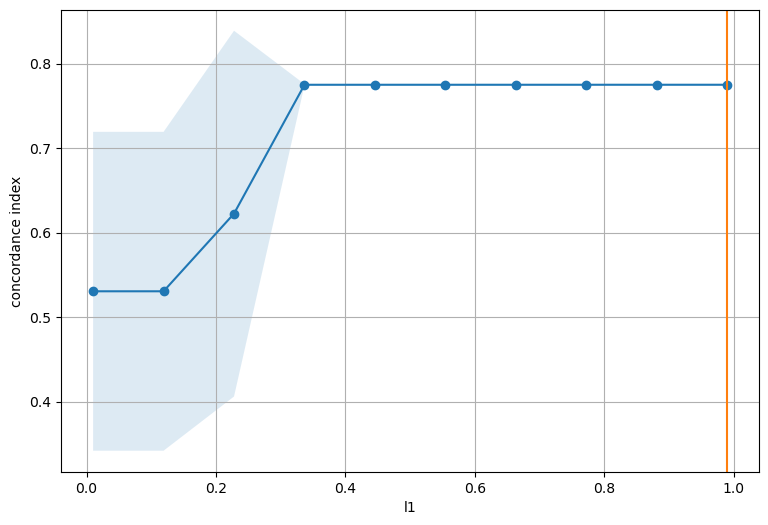

In [26]:
l1s = []
mean = []
std = []
for i, alphas in enumerate(cv_results.param_alphas):
    if from_file:
        alphas = eval(alphas)
    if alphas != best_params["alphas"]:
        continue
    l1s.append(cv_results.param_l1_ratio[i])
    mean.append(cv_results.mean_test_score[i])
    std.append(cv_results.std_test_score[i])

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(l1s, mean, "o-")
ax.fill_between(
    l1s,
    np.asarray(mean) - np.asarray(std),
    np.asarray(mean) + np.asarray(std),
    alpha=0.15,
)
ax.set_ylabel("concordance index")
ax.set_xlabel("l1")
ax.axvline(best_params["l1_ratio"], c="C1")
# ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

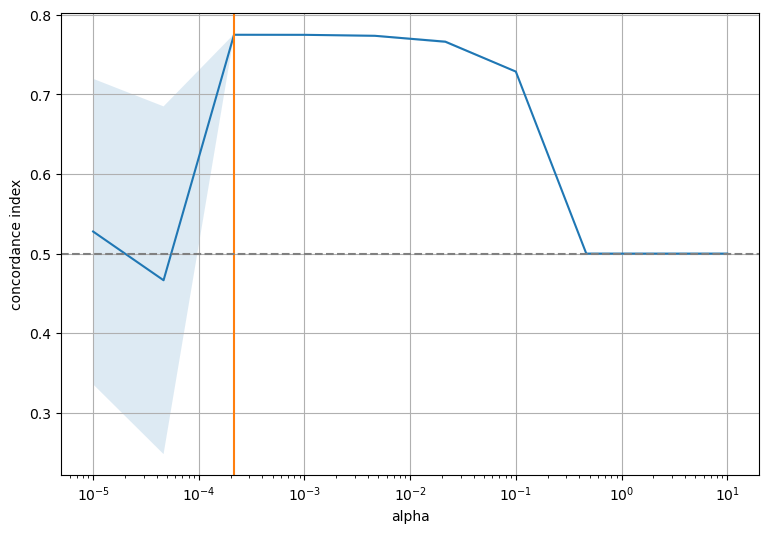

In [27]:
alphas = []
mean = []
std = []
for i, l1_ratio in enumerate(cv_results.param_l1_ratio):
    if l1_ratio != best_params["l1_ratio"]:
        continue
    alpha = cv_results.param_alphas[i]
    if from_file:
        alpha = eval(alpha)
    alphas.append(alpha[0])
    mean.append(cv_results.mean_test_score[i])
    std.append(cv_results.std_test_score[i])

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(
    alphas,
    np.asarray(mean) - np.asarray(std),
    np.asarray(mean) + np.asarray(std),
    alpha=0.15,
)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(best_params["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [28]:
# Fine-grained 1D grid search hyperparameters
n_splits = 3
n_jobs = -1
max_iter = 10000
overwrite = False
l1_ratio = best_params["l1_ratio"]
alphas = 10.0 ** np.linspace(-5, 1, 100)

In [29]:
# Perform the grid search, or load data from file if applicable
from_file = False
filename_results = "coxnet_1d_grid_search.csv"
path_results = os.path.join(get_project_root(), "models", filename_results)
if os.path.isfile(path_results) and not overwrite:
    print(f"Loading previous grid search results from {filename_results}...")
    cv_results_1d, best_params_1d = load_gridsearch_results(filename_results)
    print(f"Best parameters from previous grid search: {best_params}")
    from_file = True
else:
    coxnet_estimator = CoxnetSurvivalAnalysis(
        l1_ratio=l1_ratio,
        verbose=True,
        fit_baseline_model=False,
        max_iter=max_iter,
    )
    print(f"Running new grid search...")
    cv_results_1d, best_params_1d = run_1d_gridsearch(
        coxnet_estimator,
        X_transformed,
        y_train,
        l1_ratio=l1_ratio,
        alphas=alphas,
        n_splits=n_splits,
        n_jobs=n_jobs,
        verbose=1,
        max_iter=max_iter,
        overwrite=overwrite,
        save_best_model=True,
        save_results=True,
        filename_results=filename_results,
    )
    print(f"Best parameters from grid search: {best_params}")

Loading previous grid search results from coxnet_1d_grid_search.csv...
Loading grid search results from coxnet_1d_grid_search.csv
Best parameters from previous grid search: {'alphas': [0.00021544346900318823], 'l1_ratio': 0.99}


In [30]:
best_model = load_model("coxnet_model.pkl")

Number of non-zero coefficients: 193


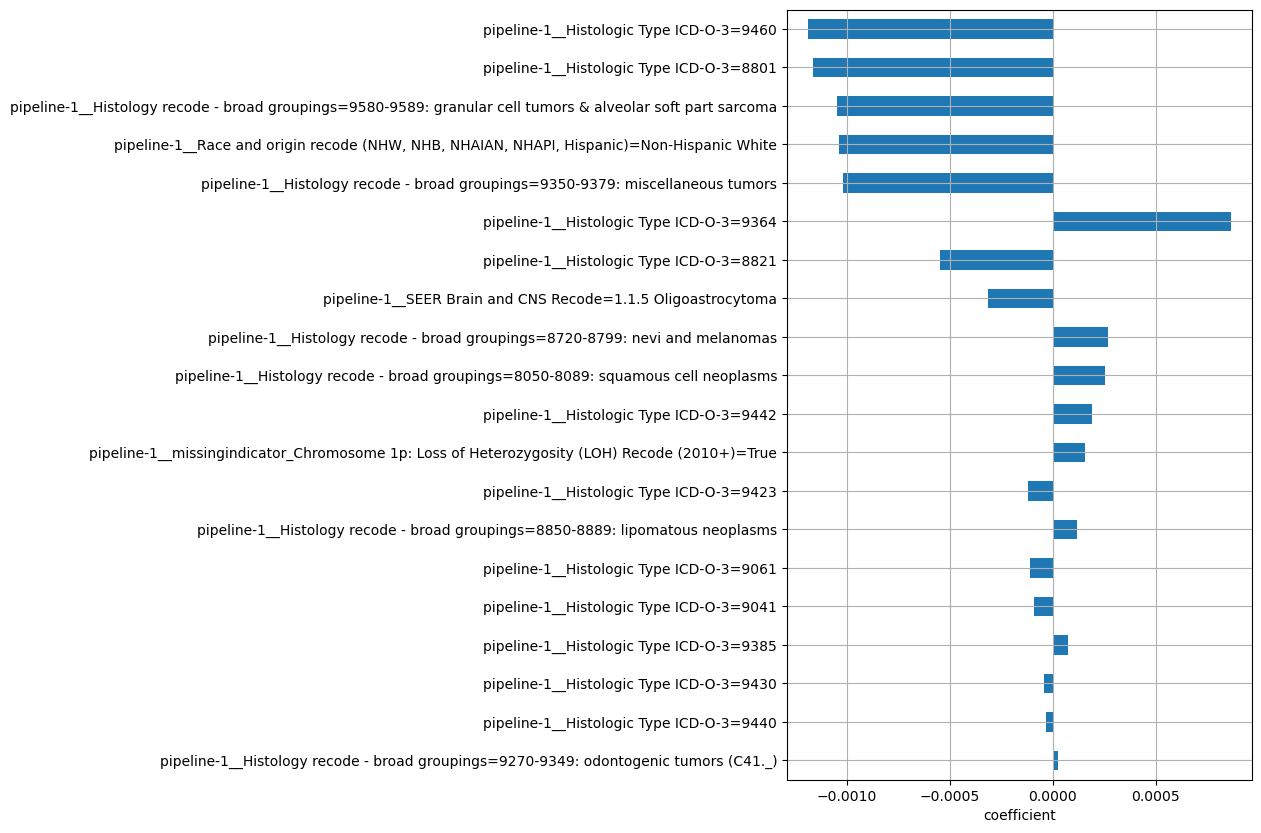

In [31]:
best_coeffs = pd.DataFrame(
    best_model.coef_, index=feature_names, columns=["coefficient"]
)

non_zero = np.sum(best_coeffs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

n_top_coefs = 20
non_zero_coefs = best_coeffs.query("coefficient != 0")
idx_best_coefs = non_zero_coefs.abs().sort_values("coefficient").head(n_top_coefs).index

_, ax = plt.subplots(figsize=(6, n_top_coefs // 2))
non_zero_coefs.loc[idx_best_coefs].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

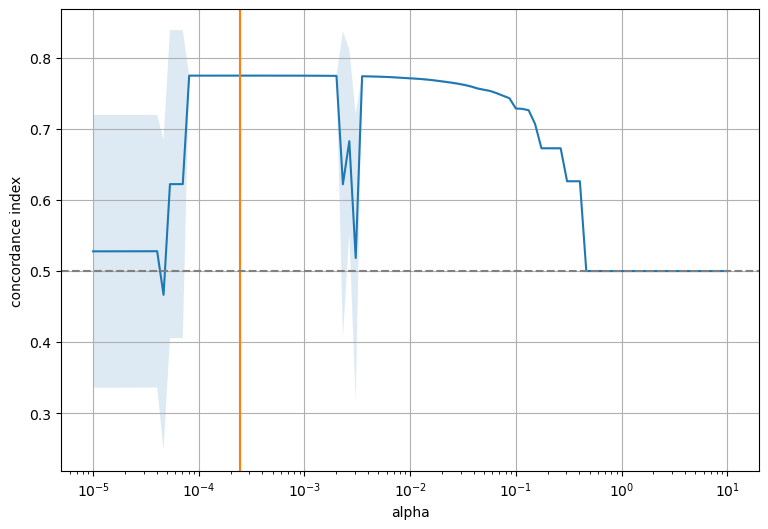

In [32]:
alphas = []
mean = []
std = []
for i, alpha in enumerate(cv_results_1d.param_alphas):
    alpha = cv_results_1d.param_alphas[i]
    if from_file:
        alpha = eval(alpha)
    alphas.append(alpha[0])
    mean.append(cv_results_1d.mean_test_score[i])
    std.append(cv_results_1d.std_test_score[i])

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(
    alphas,
    np.asarray(mean) - np.asarray(std),
    np.asarray(mean) + np.asarray(std),
    alpha=0.15,
)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(best_params_1d["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [33]:
# Re-fit the best model with fit_baseline_model enabled
coxnet_pred = CoxnetSurvivalAnalysis(verbose=True, fit_baseline_model=True)
coxnet_pred.set_params(**best_params_1d)
coxnet_pred.fit(X_transformed, y_train.to_records(index=False))

# Save the best model
save_model(coxnet_pred, "coxnet_model.pkl", overwrite=True)

In [34]:
idx_male = np.where(feature_names == "pipeline-1__Sex=Male")[0].item()
for Xt, count in zip(*np.unique(X_transformed[:, idx_male], return_counts=True)):
    print(f"Counts pipeline__Sex=Male = {Xt}: {count}")
print()
print(X_train["Sex"].value_counts())

Counts pipeline__Sex=Male = -1.1457493002312418: 26402
Counts pipeline__Sex=Male = 0.8727912814768243: 34659

Sex
Male      34659
Female    26402
Name: count, dtype: int64


In [35]:
# Not clear a priori that this is the correct labeling.
# We need to determine which feature maps to which one-hot and rescaled coefficient in general.
coeffs_to_categories = {
    -1: "Female",
    1: "Male",
}
np.unique(X_transformed[:, idx_male], return_counts=True)

(array([-1.1457493 ,  0.87279128]), array([26402, 34659]))

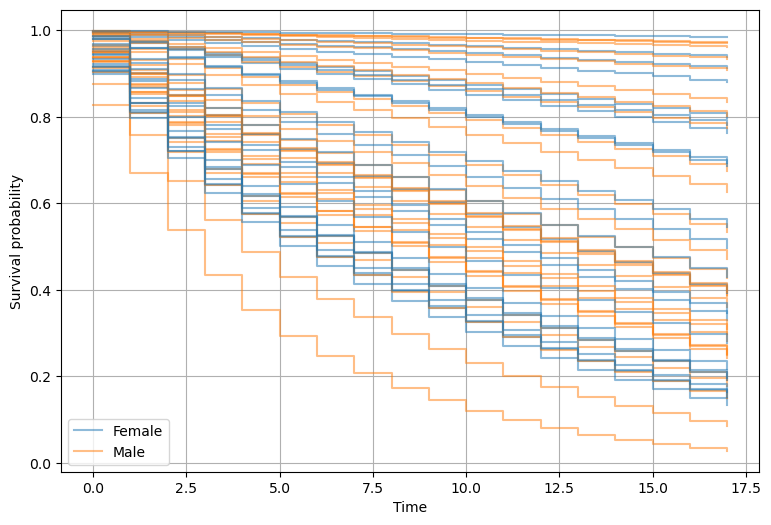

In [36]:
surv_fns = coxnet_pred.predict_survival_function(X_transformed)
idx_male = np.where(feature_names == "pipeline-1__Sex=Male")[0].item()

time_points = np.quantile(y_train["Survival months"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for i, (fn, scaled_var) in enumerate(zip(surv_fns, X_transformed[:, idx_male])):
    if i > 50:
        break
    vscale = round(scaled_var)
    name = coeffs_to_categories[vscale]
    if vscale == -1:
        label = 0
    else:
        label = 1
    (line,) = ax.step(
        time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5
    )
    if len(legend_handles) < 2:
        legend_labels.append(name)
        legend_handles.append(line)
ax.legend(legend_handles, legend_labels)
ax.set_xlabel("Time")
ax.set_ylabel("Survival probability")
ax.grid(True)